<a href="https://colab.research.google.com/github/tumblingdice512/Research/blob/master/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
N = 10
L = 5

In [36]:
S0 = torch.sign(torch.randn(20,N))

SL = torch.sign(torch.randn(20,N))


M = S0.size()[0]
print(M)
print(N)
print(S0.shape)
print(S0[0].shape)

20
10
torch.Size([20, 10])
torch.Size([10])


In [37]:
alpha = M / N
print(alpha)

2.0


In [38]:
D = torch.Tensor([[1,2,3],[2,3,4]])
print(D)
print(D.shape)
print("M:",D.size()[0]) #M
print("N:",D.size()[1]) #N

tensor([[1., 2., 3.],
        [2., 3., 4.]])
torch.Size([2, 3])
M: 2
N: 3


In [39]:
def spin_overlap(x,y):
  spin_overlap = 0
  for i in range (len(x[0])) :

    spin_overlap = spin_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(spin_overlap/(x.size()[0]*x.size()[1]))

print(spin_overlap(S0,S0))


tensor(1.)


In [40]:
def bond_overlap(x,y):
  bond_overlap = 0
  for i in range (len(x[0])) :

    bond_overlap = bond_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(bond_overlap/(x.size()[0]*x.size()[1]))

In [41]:
S_a = torch.Tensor([[1,-1],[-1,1],[1,-1]])
S_b = torch.Tensor([[1,-1],[1,1],[1,1]])
print(spin_overlap(S_a,S_b))
print(spin_overlap(S_a,S_a))

tensor(0.3333)
tensor(1.)


In [42]:
a1 = torch.dot(S_a.T[0],S_b.T[0])
a2 = torch.dot(S_a.T[1],S_b.T[1])
a3 = (a1 + a2)/(2*3)
print(a3)

tensor(0.3333)


In [43]:
def MSE(t, y):
    mse = torch.mean(torch.sum(torch.square(t-y),axis =1),axis = 0)
    return mse

In [44]:
print(MSE(S0,SL))

tensor(21.6000)


In [45]:
A = torch.Tensor([[3,5,1],[4,12,1]])
print(A**2)
A_norm = (torch.sum(torch.square(A),axis=0))**(1/2)

A_normalized = A / A_norm
A_normalized_2 = A / A_norm * (N**(1/2))

print(A_norm)

print(A_normalized)
print(A_normalized_2)

tensor([[  9.,  25.,   1.],
        [ 16., 144.,   1.]])
tensor([ 5.0000, 13.0000,  1.4142])
tensor([[0.6000, 0.3846, 0.7071],
        [0.8000, 0.9231, 0.7071]])
tensor([[1.8974, 1.2163, 2.2361],
        [2.5298, 2.9190, 2.2361]])


In [46]:
def weight_norm(x):
    x_norm = (torch.sum(torch.square(x),axis=0)**(1/2))
    return x_norm

In [47]:
w_a = torch.Tensor([[1,0,1],[1,0,0],[0,1,0]]) 
w_b = torch.Tensor([[1,0,0],[0,1,0],[0,0,1]]) 
J_a = w_a / (weight_norm(w_a)) * (3**(1/2))
J_b = w_b / (weight_norm(w_b)) * (3**(1/2))


print(J_a)
print(J_b)
print(len(J_a[0]))

print(bond_overlap(J_a,J_b))
print(bond_overlap(J_a,J_a))

tensor([[1.2247, 0.0000, 1.7321],
        [1.2247, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000]])
tensor([[1.7321, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000],
        [0.0000, 0.0000, 1.7321]])
3
tensor(0.2357)
tensor(1.)


In [48]:
class Network1(torch.nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1_1 = torch.nn.Linear(N, N, False)
        self.fc2_1 = torch.nn.Linear(N, N, False)
        self.fc3_1 = torch.nn.Linear(N, N, False)
        self.fc4_1 = torch.nn.Linear(N, N, False)
        self.fc5_1 = torch.nn.Linear(N, N, False)

        #torch.nn.init.normal_(self.fc1_1.weight, 0.0, 1.0)
        #torch.nn.init.normal_(self.fc2_1.weight, 0.0, 1.0)
        #torch.nn.init.normal_(self.fc3_1.weight, 0.0, 1.0)
        #torch.nn.init.normal_(self.fc4_1.weight, 0.0, 1.0)
        #torch.nn.init.normal_(self.fc5_1.weight, 0.0, 1.0)

 
    def forward(self, x):
        x = torch.tanh(self.fc1_1(x))
        S1_1 = torch.sign(x)
        x = torch.tanh(self.fc2_1(x))
        S2_1 = torch.sign(x)
        x = torch.tanh(self.fc3_1(x))
        S3_1 = torch.sign(x)
        x = torch.tanh(self.fc4_1(x))
        S4_1 = torch.sign(x)
        x = torch.tanh(self.fc5_1(x))
        S5_1 = torch.sign(x)

        return x, S1_1, S2_1, S3_1, S4_1, S5_1



In [49]:
if __name__ == '__main__':
    # 学習回数
    n_epoch = 10000
 
    # 学習結果の保存用
    history = {
        'train_loss_1': [],
    }
 
    # ネットワークを構築
    net: torch.nn.Module = Network1()
 
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01)
 
    for n in range(n_epoch):
 
        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net.train(True)  # 引数は省略可能
 
        optimizer.zero_grad()
        output = net(S0)
        loss = MSE(output[0], SL)
        loss.backward()
        optimizer.step()
 
        print('EPOCH ', n + 1, ' | train_loss_1 ',loss)
        
 
        history['train_loss_1'].append(loss)


ストリーミング出力は最後の 5000 行に切り捨てられました。
EPOCH  5001  | train_loss_1  tensor(0.8628, grad_fn=<MeanBackward1>)
EPOCH  5002  | train_loss_1  tensor(0.8627, grad_fn=<MeanBackward1>)
EPOCH  5003  | train_loss_1  tensor(0.8627, grad_fn=<MeanBackward1>)
EPOCH  5004  | train_loss_1  tensor(0.8627, grad_fn=<MeanBackward1>)
EPOCH  5005  | train_loss_1  tensor(0.8627, grad_fn=<MeanBackward1>)
EPOCH  5006  | train_loss_1  tensor(0.8627, grad_fn=<MeanBackward1>)
EPOCH  5007  | train_loss_1  tensor(0.8626, grad_fn=<MeanBackward1>)
EPOCH  5008  | train_loss_1  tensor(0.8626, grad_fn=<MeanBackward1>)
EPOCH  5009  | train_loss_1  tensor(0.8626, grad_fn=<MeanBackward1>)
EPOCH  5010  | train_loss_1  tensor(0.8626, grad_fn=<MeanBackward1>)
EPOCH  5011  | train_loss_1  tensor(0.8626, grad_fn=<MeanBackward1>)
EPOCH  5012  | train_loss_1  tensor(0.8625, grad_fn=<MeanBackward1>)
EPOCH  5013  | train_loss_1  tensor(0.8625, grad_fn=<MeanBackward1>)
EPOCH  5014  | train_loss_1  tensor(0.8625, grad_fn=<MeanBackward1>)
EP

{'train_loss_1': [tensor(9.9313, grad_fn=<MeanBackward1>), tensor(9.9191, grad_fn=<MeanBackward1>), tensor(9.9071, grad_fn=<MeanBackward1>), tensor(9.8951, grad_fn=<MeanBackward1>), tensor(9.8832, grad_fn=<MeanBackward1>), tensor(9.8712, grad_fn=<MeanBackward1>), tensor(9.8593, grad_fn=<MeanBackward1>), tensor(9.8474, grad_fn=<MeanBackward1>), tensor(9.8355, grad_fn=<MeanBackward1>), tensor(9.8235, grad_fn=<MeanBackward1>), tensor(9.8116, grad_fn=<MeanBackward1>), tensor(9.7995, grad_fn=<MeanBackward1>), tensor(9.7874, grad_fn=<MeanBackward1>), tensor(9.7753, grad_fn=<MeanBackward1>), tensor(9.7630, grad_fn=<MeanBackward1>), tensor(9.7507, grad_fn=<MeanBackward1>), tensor(9.7383, grad_fn=<MeanBackward1>), tensor(9.7257, grad_fn=<MeanBackward1>), tensor(9.7131, grad_fn=<MeanBackward1>), tensor(9.7003, grad_fn=<MeanBackward1>), tensor(9.6874, grad_fn=<MeanBackward1>), tensor(9.6744, grad_fn=<MeanBackward1>), tensor(9.6613, grad_fn=<MeanBackward1>), tensor(9.6479, grad_fn=<MeanBackward1>)

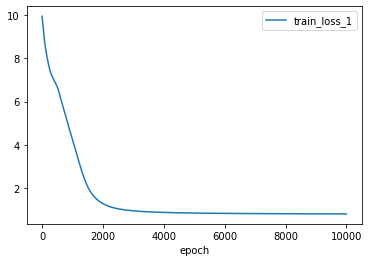

In [50]:
# 結果の出力と描画
print(history)
plt.figure()
plt.plot(range(1, n_epoch+1), history['train_loss_1'], label='train_loss_1')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss.png')
 
